# Entity extraction on Financial Complaints with Watson NLP

This notebook demonstrates how to extract _named entities_ from financial customer complaints using Watson NLP.

The data that is used in this notebook is taken from the Consumer Complaint Database that is published by the Consumer Financial Protection Bureau (CFPB), an U.S. government agency. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that the CFPB sent to companies for response.  A complaint contains a consumer’s narrative description of their experience if the consumer opts to share this information publicly and after the CFPB has taken steps to remove all personal information. In this notebook, you will focus on complaints that contain narrative descriptions to show how to use Watson NLP.

The data is publicly available at https://www.consumerfinance.gov/data-research/consumer-complaints/.

## What you'll learn in this notebook

Watson NLP offers so-called blocks for various NLP tasks. This notebooks shows:

- **Dictionary-based term extraction** with the _Rule-based extractor_ provided by `watson_nlp.resources.feature_extractor.RBR`. This allows you to train a custom extraction model based on given dictionaries.

- **Entity extraction** with the _Entity mentions block_ using the BERT model (`entity-mentions_bert_multi_stock`). This block extracts mentions of entities like *Persion*, *Organization* or *Duration* from the input text.


## Table of Contents

1.	[Before you start](#beforeYouStart)
2.	[Load the complaints](#loadData)
3.  [Custom term extraction using dictionaries](#dictionaries)
4.  [Entity extraction](#entities)
5.  [Summary](#summary)

<a id="beforeYouStart"></a>
## Before you start

You can step through the notebook execution cell by cell, by selecting Shift-Enter or you can execute the entire notebook by selecting **Cell -> Run All** from the menu. 

**Note:** If you have other notebooks currently running with the _DO + NLP Runtime 22.1 on Python 3.9_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.


Begin by importing and initializing some helper libraries that are used throughout the notebook.

In [2]:
import os
import pandas as pd
# we want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 400

In [3]:
import watson_nlp

<a id="loadData"></a>
## Load the complaints

The data can be downloaded via an API from https://www.consumerfinance.gov/data-research/consumer-complaints/. For this notebook, the complaints for one month will be downloaded and only those that contain the consumer narrative text. The data is exported in CSV format. The URL to retrieve this data is:

In [4]:
url = "https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?date_received_max=2021-03-30&date_received_min=2021-02-28&field=all&format=csv&has_narrative=true&no_aggs=true&size=18102"

Read the data into a dataframe.

You can find a detailed explanation of the available columns here: https://www.consumerfinance.gov/complaint/data-use/#:~:text=Types%20of%20complaint%20data%20we%20publish .

In the analysis, you will focus on the *Product* column and the column with the complaint text *Consumer complaint narrative*.

In [5]:
df_all = pd.read_csv(url)
text_col = 'Consumer complaint narrative'

# In this example, we take only the first 1000 complaints in the dataset for further analysis. 
# Set df to df_all to run on the complete dataset.
df_small = df_all.head(1000)
df = df_small
df.head(3)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/02/21,"Credit reporting, credit repair services, or other personal consumer reports",Credit reporting,Problem with a credit reporting company's investigation into an existing problem,Was not notified of investigation status or results,"There are several negative items on my report that I strongly believe are not accurate. I therefore submitted a dispute requesting an investigation and a response into these issues. That dispute was sent out on XX/XX/XXXX and I never received any reply. I then sent a follow-up dispute on XX/XX/XXXX. Today is now XX/XX/XXXX and I still have absolutely nothing. No investigation was undertaken, n...",None,"EQUIFAX, INC.",FL,34203,None,Consent provided,Web,03/02/21,Closed with explanation,Yes,NaN,4177885
1,03/05/21,Debt collection,I do not know,Attempts to collect debt not owed,Debt was result of identity theft,My identity has been compromised by somebody that I do not know. Please feel free to give me a call if you have any questions or concerns.,None,NCB Management Services Inc.,GA,31021,None,Consent provided,Web,03/17/21,Closed with explanation,Yes,NaN,4186175
2,03/21/21,Mortgage,Conventional home mortgage,Applying for a mortgage or refinancing an existing mortgage,None,"On XX/XX/XXXX yes, almost 1 year ago I applied for a refinance and have been patiently communicating with various individuals at Elend Mortgage LLC with no resolution. I received a formal loan estimate on XX/XX/XXXX with a rate of 3.5 % and a 2nd loan estimate on XX/XX/XXXX with a rate lock of 2.75 % During the start of this process there was a two months delay, at fault of your company, where...",None,"American Financial Resources, Inc.",AZ,85601,None,Consent provided,Web,03/21/21,Closed with explanation,Yes,NaN,4233776


You can look at all products that are available in the data set to do further analysis around these product groups.

<AxesSubplot:>

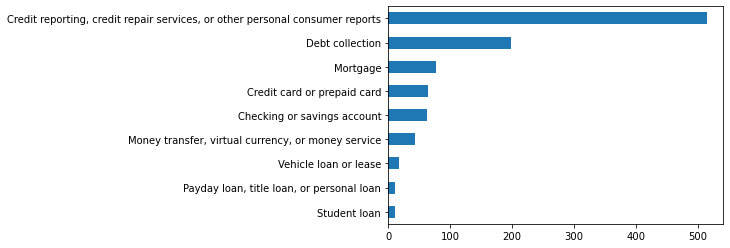

In [6]:
df['Product'].value_counts().sort_values().plot(kind='barh') 

<a id="dictionaries"></a>
## Custom term extraction using dictionaries

If you want to extract custom concepts via rule-based extraction, you can build a custom RBR model using an AQL model. However this requires knowledge of AQL. If you just want to extract custom terms or match regular expression patterns, there is a convenient way to train and run such models through `watson_nlp.resources.feature_extractor.RBR`. You only need to provide your own dictionaries or regexes and it trains an RBR model for you.

You will now create a basic dictionary that contains terms that might indicate customers suspecting a fraud concerning their financial products like the theft of a credit card.

Start with creating a folder that holds all dictionary files that you want to use for extraction.

In [7]:
import os
RBR_dicts_folder = "RBR_dicts"
os.makedirs(RBR_dicts_folder, exist_ok=True)

A dictionary can contain the dictionary terms as a flat list if all the terms are to be mapped to the same label. Alternatively, you can use a mapping dictionary that maps terms to a label. 

In this notebook, you will create a dictionary mapping file containing the fraud-related terms divided into *FRAUD* and *THEFT*. Each line has one dictionary entry.

In [8]:
fraud_file = "fraud_mappings.csv"
with open(os.path.join(RBR_dicts_folder, fraud_file), 'w') as dict:
    dict.write("\"label\", \"entry\"\n")
    dict.write("\"FRAUD\", \"fraud\"\n")
    dict.write("\"FRAUD\", \"takeover\"\n")
    dict.write("\"FRAUD\", \"skimming\"\n")
    dict.write("\"FRAUD\", \"phishing\"\n")
    dict.write("\"THEFT\", \"theft\"\n")
    dict.write("\"THEFT\", \"thief\"\n")
    dict.write("\"THEFT\", \"thieve\"\n")
    dict.write("\"THEFT\", \"steal\"\n")

In the next step, load the file as dictionary. The source dictionary path is a relative path to the created dictionary resources folder. You will use case-insensitive matching as the dictionary entries are regular words that are not likely to be miss-interpreted.

Lemma-matching will make sure that inflections of the dictionary entries will also match, for example, "steal" -> "stole", "stolen", "stealing".

In [9]:
dictionary = watson_nlp.toolkit.DictionaryConfig.load( 
    {
        'name': 'fraud_mappings',
        'source': fraud_file,
        'dict_type': 'table',
        'case': 'insensitive',
        'lemma': True,
        'mappings': {
            'columns': ['label', 'entry'],
            'entry': 'entry'
        }
    }
)

Train the RBR model using the created dictionary. This will create the unterlying AQL code.

In [10]:
trained_dict_RBR = watson_nlp.resources.feature_extractor.RBR.train(RBR_dicts_folder, language='en', dictionaries=[dictionary,])

As for the other demonstrated blocks before, create a helper method to run the RBR model on a single complaint. There is a `run()` method on the trained model, which returns the extracted concept and the span specifying the covered text.
But as you also want to see the covered text immediatly, you will access the raw response from the underlying RBR executor.

In [11]:
def extract_dictionary(complaint_text):
    RBR_result = trained_dict_RBR.executor.get_raw_response(complaint_text, language='en')
    # aggregate all matches into one array with the match label and the text evidence
    matches = []
    for view in RBR_result['annotations'].keys():
        for dict_match in RBR_result['annotations'][view]:
            matches.append(tuple((dict_match['label'], dict_match['match']['text'])))
    return matches

Now run the dictionary extraction on the complete dataframe and display the results with the complaint text.

In [12]:
# run dictionary extraction and create a dataframe holding the results
dict_matches = df[text_col].apply(lambda text: extract_dictionary(text))
dict_matches_df = pd.DataFrame(dict_matches)
dict_matches_df.rename(inplace=True, columns={text_col:'Fraud Indicators'})
# combine with the complaint dataframe
text_dict_matches_df = df[["Product", text_col]].merge(dict_matches_df, how='left', left_index=True, right_index=True)
text_dict_matches_df.head(10)

,Product,Consumer complaint narrative,Fraud Indicators
0,"Credit reporting, credit repair services, or other personal consumer reports","There are several negative items on my report that I strongly believe are not accurate. I therefore submitted a dispute requesting an investigation and a response into these issues. That dispute was sent out on XX/XX/XXXX and I never received any reply. I then sent a follow-up dispute on XX/XX/XXXX. Today is now XX/XX/XXXX and I still have absolutely nothing. No investigation was undertaken, n...",[]
1,Debt collection,My identity has been compromised by somebody that I do not know. Please feel free to give me a call if you have any questions or concerns.,[]
2,Mortgage,"On XX/XX/XXXX yes, almost 1 year ago I applied for a refinance and have been patiently communicating with various individuals at Elend Mortgage LLC with no resolution. I received a formal loan estimate on XX/XX/XXXX with a rate of 3.5 % and a 2nd loan estimate on XX/XX/XXXX with a rate lock of 2.75 % During the start of this process there was a two months delay, at fault of your company, where...",[]
3,Mortgage,I had called our mortgage company to find out why our payment went up for the month of XX/XX/2021 from XXXX to XXXX and the company said it was due to our taxes which was close to {$6000.00} then our insurance was {$2900.00}. The mortgage company said that if I could pay the escrow of the house was {$6000.00}. then my payments would remain the same but it was a fixed loan at XXXX XXXX and fixe...,[]
4,"Credit reporting, credit repair services, or other personal consumer reports","On XX/XX/XXXX2020, I called to make a {$400.00} payment due, and they had notified me of my credit balance on the account in two amounts ( lump sums ). one for {$960.00} and a second for {$2800.00} ( was {$3200.00} but they deducted the first {$390.00} payment from balance ). So in total from XXXX 2020, {$3800.00} was a credit balance from "" me '' to pay down the payment every month as told to...","[(THEFT, stealing), (FRAUD, fraud), (FRAUD, FRAUD), (FRAUD, fraud), (FRAUD, fraud), (THEFT, stolen), (FRAUD, fraud), (THEFT, theft)]"
5,"Credit reporting, credit repair services, or other personal consumer reports","I have Challenge a account ( XXXX XXXX ) on my XXXX credit bureau, after there investigation multiple times it keep coming back verified with the issue still there after I told them do delete the account for inaccuracy",[]
6,Debt collection,"Medical Revenue Services are attempting to collect on multiple debts that are either not mine, invalid and has reached the statute of limitation for collections",[]
7,Credit card or prepaid card,Received and unauthorized Chase credot card on my name with my ss. Number and address,[]
8,"Credit reporting, credit repair services, or other personal consumer reports","I have XXXX credit card accounts that were notified last XXXX that I could no longer work due to the pandemic. Payments were suspended. When I started working they settled with me, in most cases, for less than the full amount. Now they are reporting me as no/late payments for XXXX, XXXX, XXXX, XXXX and XXXX. This has killed my XXXX XXXX. I have disputed them twice and they refuse to correct th...",[]
9,"Credit reporting, credit repair services, or other personal consumer reports","My credit score dropped 100 points from XXXX in XXXX of XXXX to XXXX in XXXX of XXXX. It hasn't improved. The cause of this remarkable hit to my historically impeccable credit is deeply disconcerting as it concerns a {$20.00} payment, Discover Financial Services ' inability to contact me in writing ( they said they didn't have to ), and failure to get any relief in providing a statement to eac...",[]


Notice that "stolen" was detected as *THEFT* as the base-form *steal* is contained in the dictionary and you used lemma-matching.

How many complaints talk about *THEFT* or *FRAUD* or both? Count the complaints for each product group and display the relative frequency: 

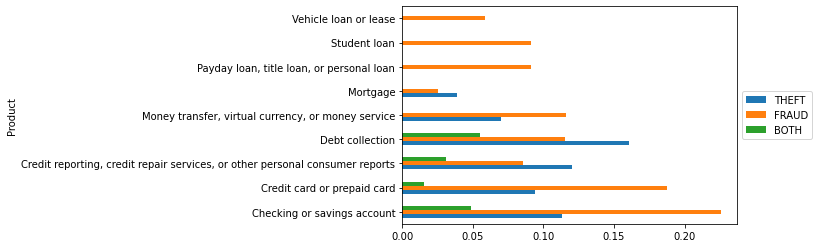

In [13]:
# create a column indicating if the complaint contains at least one *FRAUD* or *THEFT* match
text_dict_matches_df['THEFT'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'THEFT' in set([match[0] for match in matches]))
text_dict_matches_df['FRAUD'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]))
text_dict_matches_df['BOTH'] = text_dict_matches_df['Fraud Indicators'].apply(lambda matches: 'FRAUD' in set([match[0] for match in matches]) and 'THEFT' in set([match[0] for match in matches]))

# get the relative frequency by product group
perc_theft = text_dict_matches_df.groupby('Product')['THEFT'].value_counts(normalize=True)
perc_fraud = text_dict_matches_df.groupby('Product')['FRAUD'].value_counts(normalize=True)
perc_both = text_dict_matches_df.groupby('Product')['BOTH'].value_counts(normalize=True)
# combine the values into one dataframe
res = pd.concat([perc_theft, perc_fraud, perc_both], axis=1).reset_index().rename(columns={"level_1": "is_contained"})
# only use the counts for rows indicating a match
res = res[res['is_contained']].drop('is_contained', axis=1).set_index('Product')
res.plot.barh().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))


Nearly 15% of the Money transfer/service complaints seem to deal with theft and over 25% of the checking or savings account complaints with fraud.

<a id="entities"></a>
## Entity extraction

The complaints contain a lot of entity mentions about entities like organizations, money, durations, etc. In this section you will learn how to use the BERT entity mention extraction block, which extracts entity mentions out-of-the-box. 

The BERT entity mention model depends on the syntax model. Start with loading both models:

In [14]:
syntax_model = watson_nlp.load(watson_nlp.download('syntax_izumo_en_stock'))
bert_entity_model = watson_nlp.load(watson_nlp.download('entity-mentions_bert_multi_stock'))

The helper method first runs the syntax model and then the entity extraction model on top of the syntax result:

In [15]:
def extract_entities(complaint_text):
    # run syntax model
    syntax_result = syntax_model.run(complaint_text, parsers=('token', 'lemma', 'part_of_speech'))
    # run the entity mention model on the result of the syntax model
    entity_mentions = bert_entity_model.run(syntax_result)
    # get text and type of entities
    entities = entity_mentions.get_mention_pairs()
    return entities

Run the entity extraction model on the complaint dataframe and show the extracted entities along with the complaint text. **Note:** This cell will run for several minutes.

In [20]:
# run entity extraction and create a dataframe holding the results
entities = df[text_col].apply(lambda text: extract_entities(text))
entities_df = pd.DataFrame(entities)
entities_df.rename(inplace=True, columns={text_col:'Entities'})
# combine with our complaint dataframe
text_entities_df = df[["Product", text_col]].merge(entities_df, how='left', left_index=True, right_index=True)
text_entities_df.head()

,Product,Consumer complaint narrative,Entities
0,"Credit reporting, credit repair services, or other personal consumer reports","There are several negative items on my report that I strongly believe are not accurate. I therefore submitted a dispute requesting an investigation and a response into these issues. That dispute was sent out on XX/XX/XXXX and I never received any reply. I then sent a follow-up dispute on XX/XX/XXXX. Today is now XX/XX/XXXX and I still have absolutely nothing. No investigation was undertaken, n...","[(Today, Date)]"
1,Debt collection,My identity has been compromised by somebody that I do not know. Please feel free to give me a call if you have any questions or concerns.,[]
2,Mortgage,"On XX/XX/XXXX yes, almost 1 year ago I applied for a refinance and have been patiently communicating with various individuals at Elend Mortgage LLC with no resolution. I received a formal loan estimate on XX/XX/XXXX with a rate of 3.5 % and a 2nd loan estimate on XX/XX/XXXX with a rate lock of 2.75 % During the start of this process there was a two months delay, at fault of your company, where...","[(1 year ago, Date), (Elend Mortgage LLC, Organization), (2nd, Ordinal), (two months, Duration), (Loan Processor, Organization), (second, Ordinal), (Loan Processor, Organization), (XX/, Date), (/, Date), (Loan Processors, Organization), (Loan Processor, Organization), (second, Ordinal), (Loan Processor, Organization), (XXXX County, Location), (two months, Duration), (XX, Date), (a year, Durati..."
3,Mortgage,I had called our mortgage company to find out why our payment went up for the month of XX/XX/2021 from XXXX to XXXX and the company said it was due to our taxes which was close to {$6000.00} then our insurance was {$2900.00}. The mortgage company said that if I could pay the escrow of the house was {$6000.00}. then my payments would remain the same but it was a fixed loan at XXXX XXXX and fixe...,"[(XX/XX/2021, Date), (XXXX, Date), ($6000.00, Money), ($2900.00, Money), ($6000.00, Money), (XXXX XXXX, Money), (XXXX yrs, Money)]"
4,"Credit reporting, credit repair services, or other personal consumer reports","On XX/XX/XXXX2020, I called to make a {$400.00} payment due, and they had notified me of my credit balance on the account in two amounts ( lump sums ). one for {$960.00} and a second for {$2800.00} ( was {$3200.00} but they deducted the first {$390.00} payment from balance ). So in total from XXXX 2020, {$3800.00} was a credit balance from "" me '' to pay down the payment every month as told to...","[(2020, Date), ($400.00, Money), ($960.00, Money), (second, Ordinal), ($2800.00, Money), ($3200.00, Money), (first, Ordinal), ($390.00, Money), (2020, Date), ($3800.00, Money), (every month, Date), (10 months, Duration), ($100.00, Money), ($960.00, Money), (XXXX, Location), (XXXX, Location), (XXXX, Location), (XXXX, Location), (representatives, JobTitle), (-30 days, Duration), (XXXX -60, Durat..."


Let's see what kind of entities are extracted from the complaints:

<AxesSubplot:>

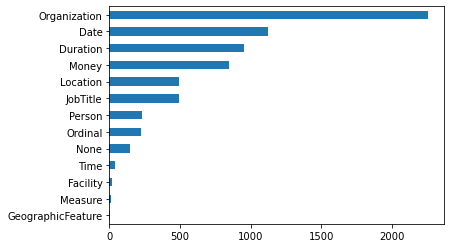

In [21]:
# helper method to extract the mention type from the (text, type) tuple
def get_entity_type(ent):
    if not pd.isna(ent):
        return ent[1]
    return 'None'

# create separate rows for each entity mention
exp_entities = text_entities_df.explode('Entities')
# extract the entity type of each mention
exp_entities['Entity Type'] = exp_entities['Entities'].apply(lambda ent: get_entity_type(ent))
# count the number of occurrences for each entity type
exp_entities['Entity Type'].value_counts().head(20).sort_values().plot(kind='barh') 

Show the relative frequency of each entity type by product:

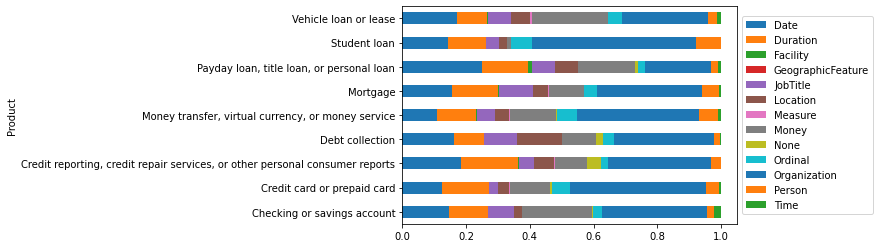

In [22]:
unstacked = exp_entities.groupby('Product')['Entity Type'].value_counts(normalize=True).unstack()
unstacked.plot.barh(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

*Job Titles* are frequently mentioned in the *Vechicle loan or lease* product group and there is a high number of *Location* mentions for the product group *Debt collection*. Let's look at some sample texts for the job titles:

In [23]:
exp_entities.query('`Entity Type` == "JobTitle" and Product == "Vehicle loan or lease"').head()

,Product,Consumer complaint narrative,Entities,Entity Type
29,Vehicle loan or lease,Leased Vehicle : XXXX XXXX XXXX XXXX XXXX XXXX Maturity Date : XX/XX/XXXX Based on the letter received from Hyundai on XX/XX/XXXX the total amount due was {$1100.00} which was not aligned to the payoff quote received when returning the vehicle. \nThe payoff quote and check issued for final payment was XXXX ( {$320.00} x 3 months left ). \n\nPlease note that payoff quote received on XXXX from ...,"(salesperson, JobTitle)",JobTitle
29,Vehicle loan or lease,Leased Vehicle : XXXX XXXX XXXX XXXX XXXX XXXX Maturity Date : XX/XX/XXXX Based on the letter received from Hyundai on XX/XX/XXXX the total amount due was {$1100.00} which was not aligned to the payoff quote received when returning the vehicle. \nThe payoff quote and check issued for final payment was XXXX ( {$320.00} x 3 months left ). \n\nPlease note that payoff quote received on XXXX from ...,"(managers, JobTitle)",JobTitle
29,Vehicle loan or lease,Leased Vehicle : XXXX XXXX XXXX XXXX XXXX XXXX Maturity Date : XX/XX/XXXX Based on the letter received from Hyundai on XX/XX/XXXX the total amount due was {$1100.00} which was not aligned to the payoff quote received when returning the vehicle. \nThe payoff quote and check issued for final payment was XXXX ( {$320.00} x 3 months left ). \n\nPlease note that payoff quote received on XXXX from ...,"(financial, JobTitle)",JobTitle
39,Vehicle loan or lease,"The NYS Attorney General has sent me here for this matter. In late XX/XX/XXXX, I went to a XXXX dealership in XXXX NY to apply for a loan on a XXXX XXXX XXXX. At first they stated that I was approved for payments around {$450.00} a month. then after agreeing they came back and said they made a mistake somewhere and my payments would actually be {$660.00} a month. I was a young and uneducated o...","(NYS, JobTitle)",JobTitle
39,Vehicle loan or lease,"The NYS Attorney General has sent me here for this matter. In late XX/XX/XXXX, I went to a XXXX dealership in XXXX NY to apply for a loan on a XXXX XXXX XXXX. At first they stated that I was approved for payments around {$450.00} a month. then after agreeing they came back and said they made a mistake somewhere and my payments would actually be {$660.00} a month. I was a young and uneducated o...","(Attorney General, JobTitle)",JobTitle


<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained model for entity extraction. You learned how easy you can extract custom terms using dictionaries.

### Authors
Simone Zerfass IBM, Germany

Alexander Lang IBM, Germany

# <hr>
Copyright © 2021-2022 IBM. This notebook and its source code are released under the terms of the MIT License.